In [1]:
import torch
# Choose the `slowfast_r50` model 
model = torch.hub.load('facebookresearch/pytorchvideo', 'slowfast_r101', pretrained=True)

Using cache found in /home/aiscuser/.cache/torch/hub/facebookresearch_pytorchvideo_main


[2024-04-28 00:25:30,605] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/aiscuser/.conda/envs/vid2/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_validation.py:118: UserWarning: onnxruntime training package info: package_name: onnxruntime-training
  warnings.warn("onnxruntime training package info: package_name: %s" % package_name)
/home/aiscuser/.conda/envs/vid2/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_validation.py:119: UserWarning: onnxruntime training package info: __version__: 1.17.1
  warnings.warn("onnxruntime training package info: __version__: %s" % version)
/home/aiscuser/.conda/envs/vid2/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_validation.py:120: UserWarning: onnxruntime training package info: cuda_version: 12.2
  warnings.warn("onnxruntime training package info: cuda_version: %s" % cuda_version)
/home/aiscuser/.conda/envs/vid2/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_validation.py:121: UserWarning: onnxruntime build info: cudart_version: 12020
  warnings.warn("onnxruntime build 

In [2]:
from typing import Dict
import json
import urllib
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
    UniformCropVideo
)

/home/aiscuser/.conda/envs/vid2/lib/python3.10/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/aiscuser/.conda/envs/vid2/lib/python3.10/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [3]:
device = "cuda:1"
model = model.eval()
model = model.to(device)

In [4]:
side_size = 256
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
crop_size = 256
num_frames = 32
sampling_rate = 2
frames_per_second = 30
slowfast_alpha = 4
num_clips = 10
num_crops = 3

class PackPathway(torch.nn.Module):
    """
    Transform for converting video frames as a list of tensors. 
    """
    def __init__(self):
        super().__init__()
        
    def forward(self, frames: torch.Tensor):
        fast_pathway = frames
        # Perform temporal sampling from the fast pathway.
        slow_pathway = torch.index_select(
            frames,
            1,
            torch.linspace(
                0, frames.shape[1] - 1, frames.shape[1] // slowfast_alpha
            ).long(),
        )
        frame_list = [slow_pathway, fast_pathway]
        return frame_list

inverse_subsample = ApplyTransformToKey(
    key="video",
    transform = Compose(
        [
            NormalizeVideo(
                mean= [-m/s for m, s in zip(mean, std)],
                std= [1/s for s in std]
            ),
            Lambda(lambda x: x*255),
        ]
    ),
)
transform_subsample = ApplyTransformToKey(
    key="video",
    transform = Compose(
        [
            UniformTemporalSubsample(num_frames),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(
                size=side_size
            ),
            CenterCropVideo(crop_size),
        ]
    ),
)

transform =  ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            # UniformTemporalSubsample(num_frames),
            # Lambda(lambda x: x/255.0),
            # NormalizeVideo(mean, std),
            # ShortSideScale(
            #     size=side_size
            # ),
            # CenterCropVideo(crop_size),
            PackPathway()
        ]
    ),
)

# The duration of the input clip is also specific to the model.
clip_duration = (num_frames * sampling_rate)/frames_per_second

In [5]:
url_link = "https://dl.fbaipublicfiles.com/pytorchvideo/projects/archery.mp4"
video_path = 'archery.mp4'
try: urllib.URLopener().retrieve(url_link, video_path)
except: urllib.request.urlretrieve(url_link, video_path)

In [6]:
video_path = 'vidmodex_output_16.avi'
# video_path = 'makeup.avi'


In [7]:
start_sec = 0
end_sec = start_sec + clip_duration

# Initialize an EncodedVideo helper class and load the video
video = EncodedVideo.from_path(video_path)

# Load the desired clip
video_data_raw = video.get_clip(start_sec=start_sec, end_sec=end_sec)
video_data_raw = transform_subsample(video_data_raw)
# Apply a transform to normalize the video input
video_data = transform(video_data_raw)

# Move the inputs to the desired device
inputs = video_data["video"]
inputs = [i.to(device)[None, ...] for i in inputs]

In [8]:
video_data_raw = video.get_clip(start_sec=start_sec, end_sec=end_sec)
print(video_data_raw["video"].mean(), video_data_raw["video"].std(), video_data_raw["video"].min(), video_data_raw["video"].max())

video_data_raw = transform_subsample(video_data_raw)
print(video_data_raw["video"].mean(), video_data_raw["video"].std(), video_data_raw["video"].min(), video_data_raw["video"].max())
video_data_raw = inverse_subsample(video_data_raw)
print(video_data_raw["video"].mean(), video_data_raw["video"].std(), video_data_raw["video"].min(), video_data_raw["video"].max())
video_data_raw = transform_subsample(video_data_raw)
print(video_data_raw["video"].mean(), video_data_raw["video"].std(), video_data_raw["video"].min(), video_data_raw["video"].max())


tensor(123.9088) tensor(7.8829) tensor(96.) tensor(148.)
tensor(0.1596) tensor(0.1315) tensor(-0.2740) tensor(0.5319)
tensor(123.9044) tensor(7.5428) tensor(99.0312) tensor(145.2656)
tensor(0.1596) tensor(0.1315) tensor(-0.2740) tensor(0.5319)


In [9]:
import gc
def fetch_topk_probs(preds, k=5):
    topk_probs, topk_idxs = preds.topk(k)
    mask = torch.zeros_like(preds, dtype=torch.bool)
    mask.scatter_(1, topk_idxs, True)
    # mask = torch.zeros_like(preds)
    # mask[torch.arange(mask.size(0)), topk_idxs] = 1.
    rem_prob = (1. - topk_probs.sum(-1))/(preds.shape[-1]-k)
    out_probs = torch.einsum("j,jk->jk",rem_prob, torch.ones(preds.shape).to(device=preds.device))
    out_probs[mask.to(dtype=torch.bool)] = preds[mask.to(dtype=torch.bool)]
    # out_probs.index_put_((topk_idxs[], topk_idxs[]), topk_probs)
    # print(torch.index_select(out_probs, 1, topk_idxs))
    return out_probs

def call_vid(videos):
    input_slow = []
    input_fast = []
    for i in range(videos.shape[0]):
        vid = {"video":torch.from_numpy(videos[i,...])}
        video_dict = transform(vid)
        inputs = video_dict["video"]
        input_slow.append(inputs[0].to(device))
        input_fast.append(inputs[1].to(device))
        
    input_slow = torch.stack(input_slow, dim=0).to(device)
    input_fast = torch.stack(input_fast, dim=0).to(device)
    with torch.no_grad():
        pred = model([input_slow, input_fast])
        post_act = torch.nn.Softmax(dim=1)
        preds = post_act(pred)
    
    torch.cuda.empty_cache()
    gc.collect()
    return fetch_topk_probs(preds,5)
    

In [10]:
from torch.nn import functional as F

In [11]:
# import vidmodex
# import importlib
# importlib.reload(vidmodex)
from vidmodex.loss import ShapLoss


/home/aiscuser/.conda/envs/vid2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
loss = ShapLoss(call_vid, video_data_raw["video"], max_evals=128)

/home/aiscuser/.conda/envs/vid2/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [13]:
X = video_data_raw["video"]

In [14]:
from torch import nn
import sys
sys.path.append("/home/aiscuser")
from discriminator_models import UNet
sys.path.pop(-1)
shap_prob_model = UNet(n_channels=3, n_classes=1, width_multiplier=1, trilinear=True, prob_out=True, use_ds_conv=False) #.to('cuda:0')

checkpoint = torch.load("/home/aiscuser/discriminator/unet2_prob/version_14/checkpoints/epoch=99-step=600.ckpt")
for key in list(checkpoint["state_dict"].keys()):
    if "model." in key:
        checkpoint["state_dict"][key.replace("model.","")] = checkpoint["state_dict"].pop(key)
shap_prob_model.load_state_dict(checkpoint["state_dict"])


<All keys matched successfully>

In [132]:
mu, logvar = shap_prob_model(X.reshape(-1, *X.shape))
sigma = torch.exp(0.5 * logvar)

In [113]:
loss.set_max_evals(128)

In [114]:
loss.batch_size=50

In [141]:
loss_item, (shap_gt, shap_gt_min, shap_gt_max) = loss(X.reshape(-1, *X.shape), mu, sigma, optimize_prob=True,optimize_energy=False)

PartitionExplainer explainer: 2it [00:12, 12.95s/it]               


2.3265791043725112e-08 -6.096634782200756e-08 9.244381971029725e-08

shap_gt 0.036401388580705886 -1.0 1.0 
shap_gt_min (1,) -6.777809424818315e-08 -6.777809424818315e-08 -6.777809424818315e-08 
shap_gt_max (1,) 1.9770875070435068e-07 1.9770875070435068e-07 1.9770875070435068e-07

shap_gt_tensor tensor(0.5829) tensor(-0.0823) tensor(1.)
torch.Size([1, 1, 32, 256, 256]) torch.Size([1, 1, 32, 256, 256]) torch.Size([1, 1, 32, 256, 256]) torch.Size([1, 1, 32, 256, 256])


In [142]:
loss_item, (shap_gt, _, _) = loss(X.reshape(-1, *X.shape), mu, sigma, optimize_prob=False,optimize_energy=True, shap_gt=shap_gt)

torch.Size([1, 1, 32, 256, 256]) tensor(-9.3679e+14, grad_fn=<MeanBackward0>) tensor(-1.7138e+17, grad_fn=<MinBackward1>) tensor(-0.0147, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 32, 256, 256]) tensor(0.0198, grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MinBackward1>) tensor(0.9854, grad_fn=<MaxBackward1>)


In [143]:
loss_item

tensor(-134.0352, grad_fn=<MulBackward0>)

In [144]:
shap_gt.shape

torch.Size([1, 1, 32, 256, 256])

In [145]:
prob_val = loss.compute_norm_prob(mu, sigma, shap_gt)

torch.Size([1, 1, 32, 256, 256]) tensor(-9.3679e+14, grad_fn=<MeanBackward0>) tensor(-1.7138e+17, grad_fn=<MinBackward1>) tensor(-0.0147, grad_fn=<MaxBackward1>)


In [146]:
prob_val.shape, prob_val.mean(), prob_val.min(), prob_val.max(), prob_val.std()

(torch.Size([1, 1, 32, 256, 256]),
 tensor(0.0198, grad_fn=<MeanBackward0>),
 tensor(0., grad_fn=<MinBackward1>),
 tensor(0.9854, grad_fn=<MaxBackward1>),
 tensor(0.0914, grad_fn=<StdBackward0>))

<Axes: >

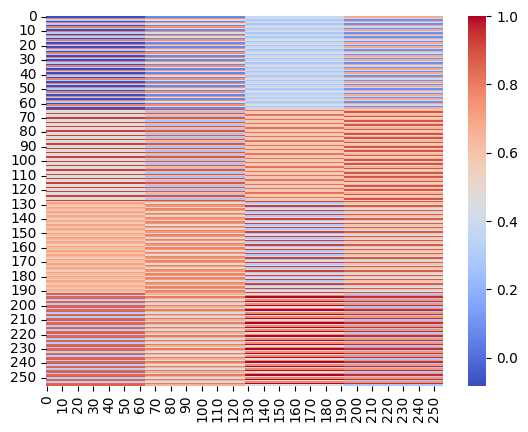

In [147]:
import seaborn as sns
from shap.plots.colors import red_transparent_blue
sns.heatmap(shap_gt[0,0,0].cpu().detach().numpy(), cmap="coolwarm")

<Axes: >

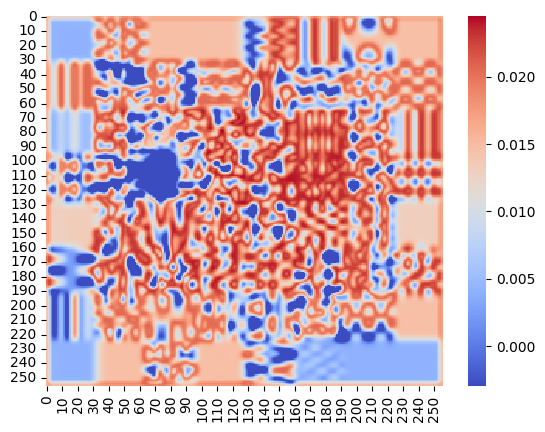

In [148]:
sns.heatmap(mu[0,0,0].cpu().detach().numpy(), cmap="coolwarm")

<Axes: >

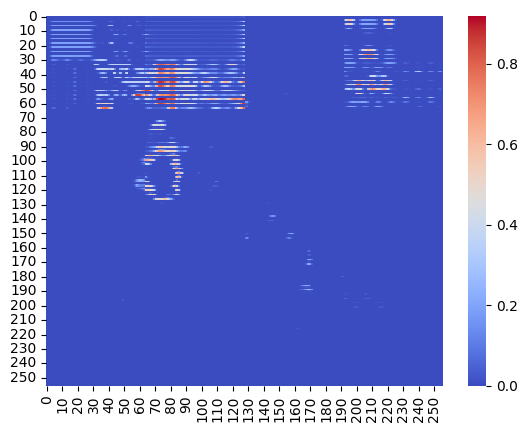

In [149]:
sns.heatmap(prob_val[0,0,0].cpu().detach().numpy(), cmap="coolwarm")